In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np

In [2]:
def analysis_plot(solution_df: pd.DataFrame):
    # Set 'time-step' as the index
    solution_df.set_index('time-step', inplace=True)

    # Create a figure with subplots
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Parameters over Time Steps')

    # Plot each parameter in a separate subplot
    for (param, ax) in zip(solution_df.columns, axs.ravel()):
        solution_df[param].plot(ax=ax, marker='o')
        ax.set_title(param)
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Value')
        ax.grid(True)

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

In [3]:
def calculate_stats(df: pd.DataFrame):
    # Calculate mean and median for each column
    results = {}
    for column in df.columns:
        results[column] = {
            "mean": df[column].mean(),
            "median": df[column].median()
        }
    
    return results

In [4]:
solution_artem_v1_df = pd.read_json('../data/solution_artem_v1_analysis.json')
solution_example_df = pd.read_json('../data/solution_example_analysis.json')

FileNotFoundError: File ../data/solution_artem_v1_analysis.json does not exist

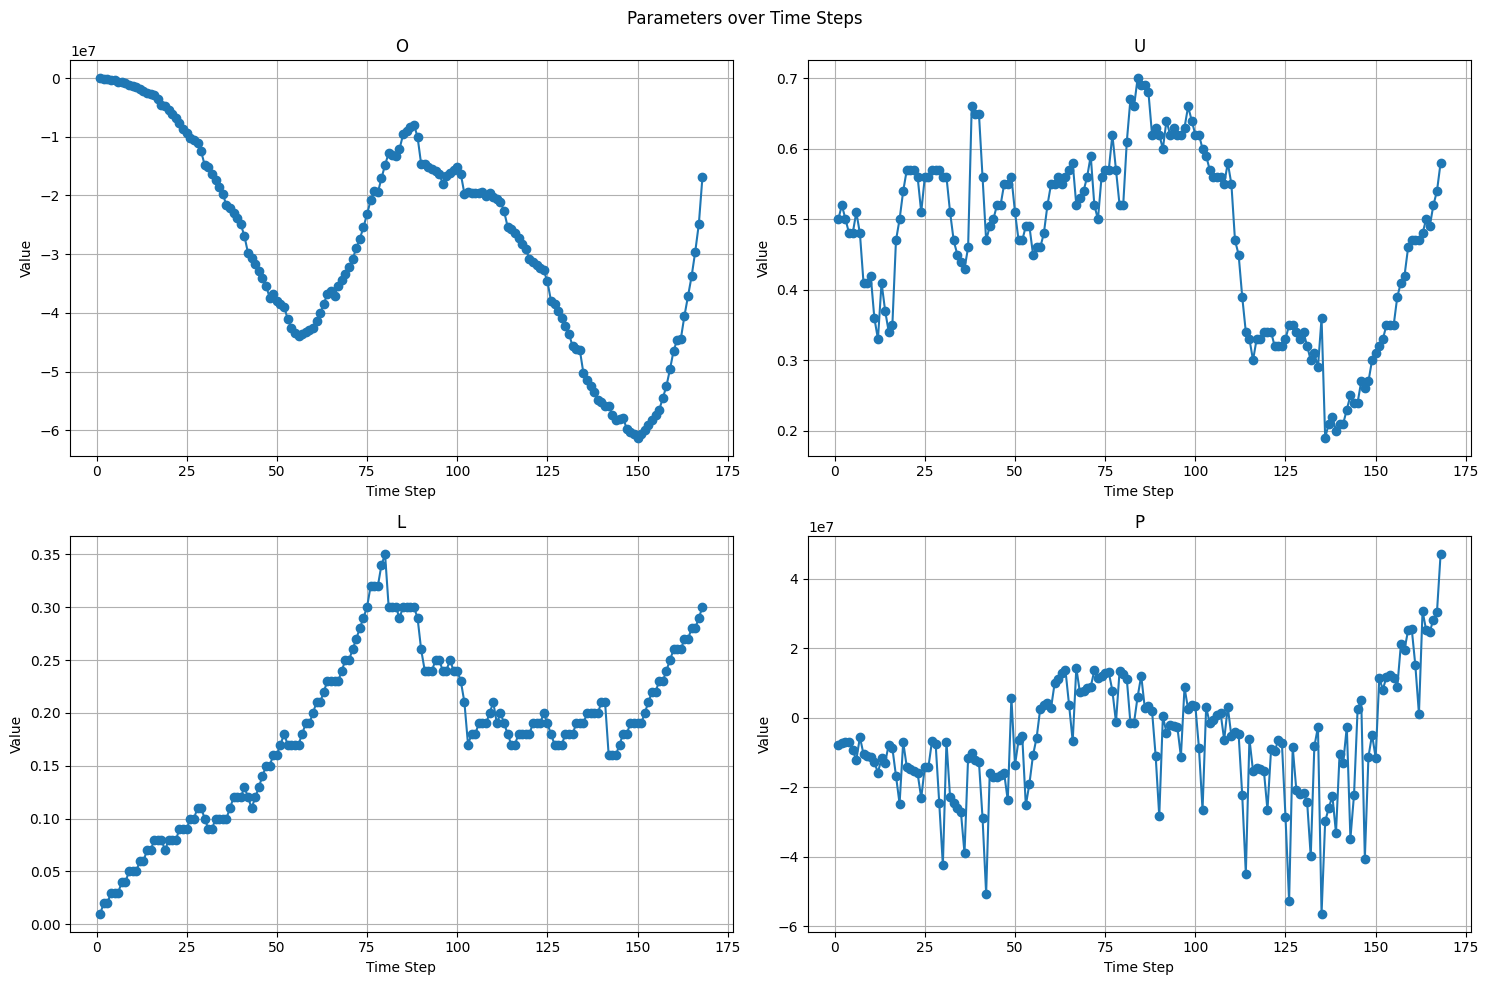

In [ ]:
analysis_plot(solution_artem_v1_df)

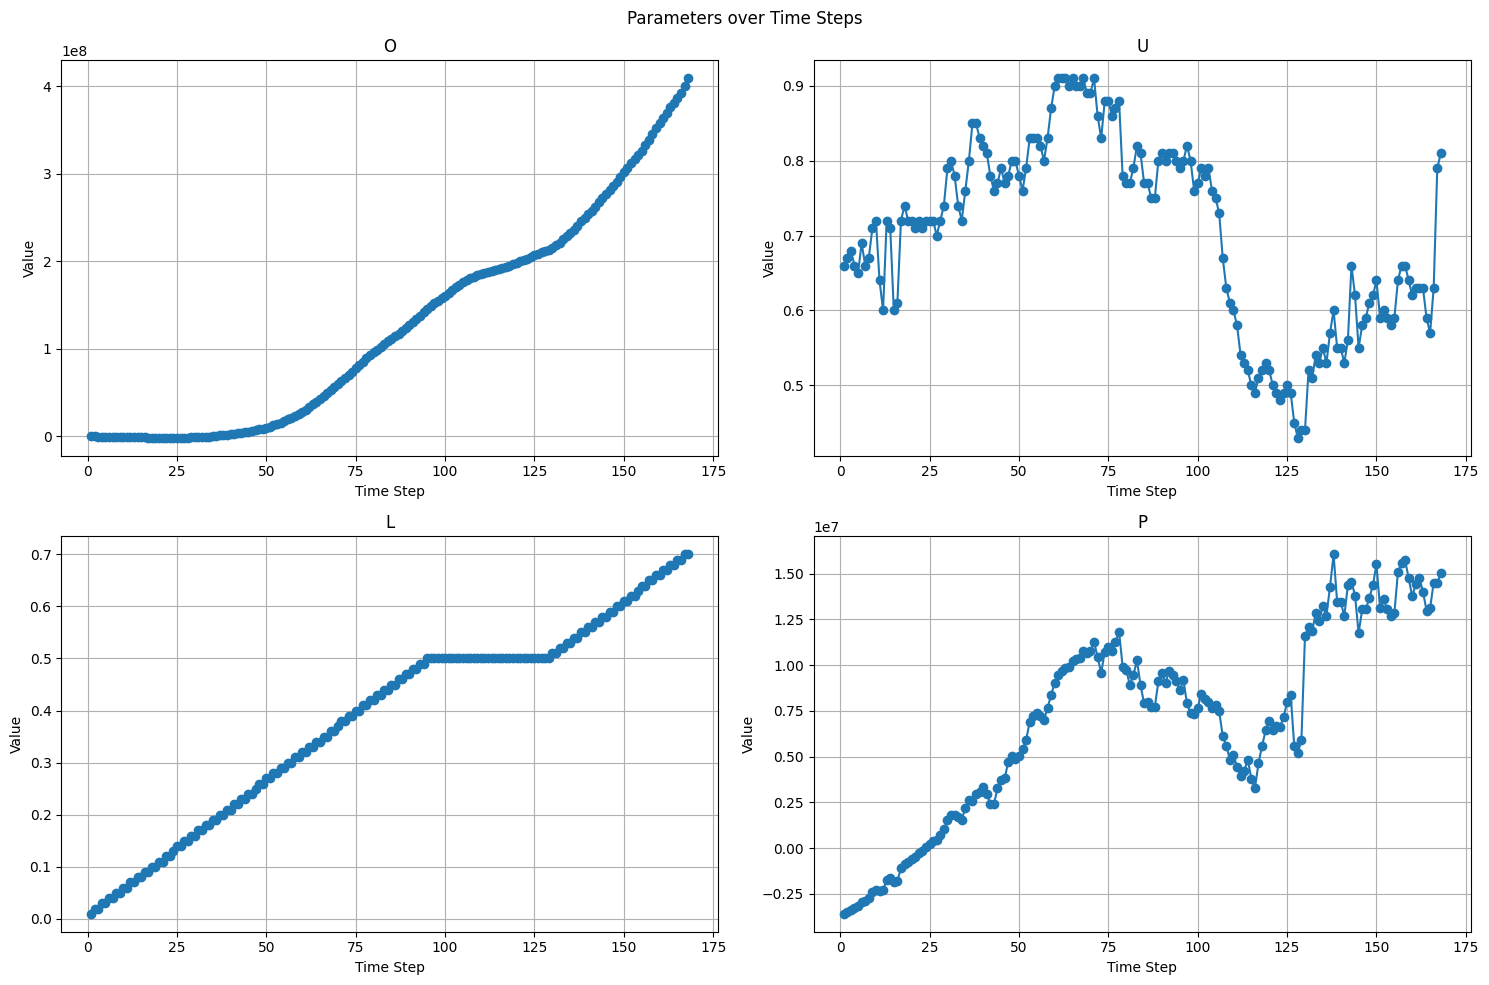

In [ ]:
analysis_plot(solution_example_df)

In [5]:
calculate_stats(solution_artem_v1_df)

NameError: name 'solution_artem_v1_df' is not defined

In [ ]:
calculate_stats(solution_example_df)

{'O': {'mean': 127125370.60351193, 'median': 110452169.08500001},
 'U': {'mean': 0.7030952380952381, 'median': 0.72},
 'L': {'mean': 0.3857738095238095, 'median': 0.445},
 'P': {'mean': 7056430.63470238, 'median': 7691781.155}}

In [6]:
def ma_demand_plot(actual_demand: pd.DataFrame, window_size: int = 7):
    server_generations = actual_demand['server_generation'].unique()
    
    # Create subplots vertically
    _, axes = plt.subplots(len(server_generations), 1, figsize=(12, 8 * len(server_generations)))
    plt.subplots_adjust(left=0.2)  # Make room for check buttons
    
    colors = {'high': 'red', 'medium': 'green', 'low': 'blue'}
    
    # Plot for each server generation
    for i, generation in enumerate(server_generations):
        df_gen = actual_demand[actual_demand['server_generation'] == generation]
        
        ax = axes[i]
        
        for column in ['high', 'medium', 'low']:
            color = colors[column]
            
            # Plot original data
            ax.plot(df_gen['time_step'], df_gen[column], label=f'{column.capitalize()}', 
                    color=color, marker='o', alpha=0.5)
            
            # Calculate and plot moving average
            moving_avg = df_gen[column].rolling(window=window_size, center=True, min_periods=1).mean()
            ax.plot(df_gen['time_step'], moving_avg, label=f'{column.capitalize()} MA', 
                    color=f'dark{color}', linestyle='-', linewidth=2)
        
        ax.set_title(f'Demand Trajectory for {generation}')
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Demand')
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

In [13]:
actual_demand = pd.read_csv('../data/test_data/actual_demand_1741.csv').drop('Unnamed: 0', axis=1)

In [66]:
def gap_demand_plot(actual_demand: pd.DataFrame, gap_size: int = 7):
    server_generations = actual_demand['server_generation'].unique()
    
    # Create subplots vertically
    _, axes = plt.subplots(len(server_generations), 1, figsize=(12, 8 * len(server_generations)))
    plt.subplots_adjust(left=0.2)  # Make room for check buttons
    
    colors = {'high': 'red', 'medium': 'green', 'low': 'blue'}
    
    # Plot for each server generation
    for i, generation in enumerate(server_generations):
        df_gen = actual_demand[actual_demand['server_generation'] == generation]
        
        # Calculate gap data
        gap_df = df_gen[df_gen['time_step'] % gap_size == 0].drop('Unnamed: 0', axis=1)
        gap_df.to_csv('gap_df.csv')

        ax = axes[i]
        
        for column in ['high', 'medium', 'low']:
            color = colors[column]
            
            # Plot original data
            ax.plot(df_gen['time_step'], df_gen[column], label=f'{column.capitalize()}', 
                    color=color, marker='o', alpha=0.5)
            
            # Plot gap data
            ax.plot(gap_df['time_step'], gap_df[column], label=f'{column.capitalize()} Gap {gap_size}',
                    color=f'dark{color}', linestyle='-', linewidth=2, marker='o')
            
        
        ax.set_title(f'Demand Trajectory for {generation}')
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Demand')
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

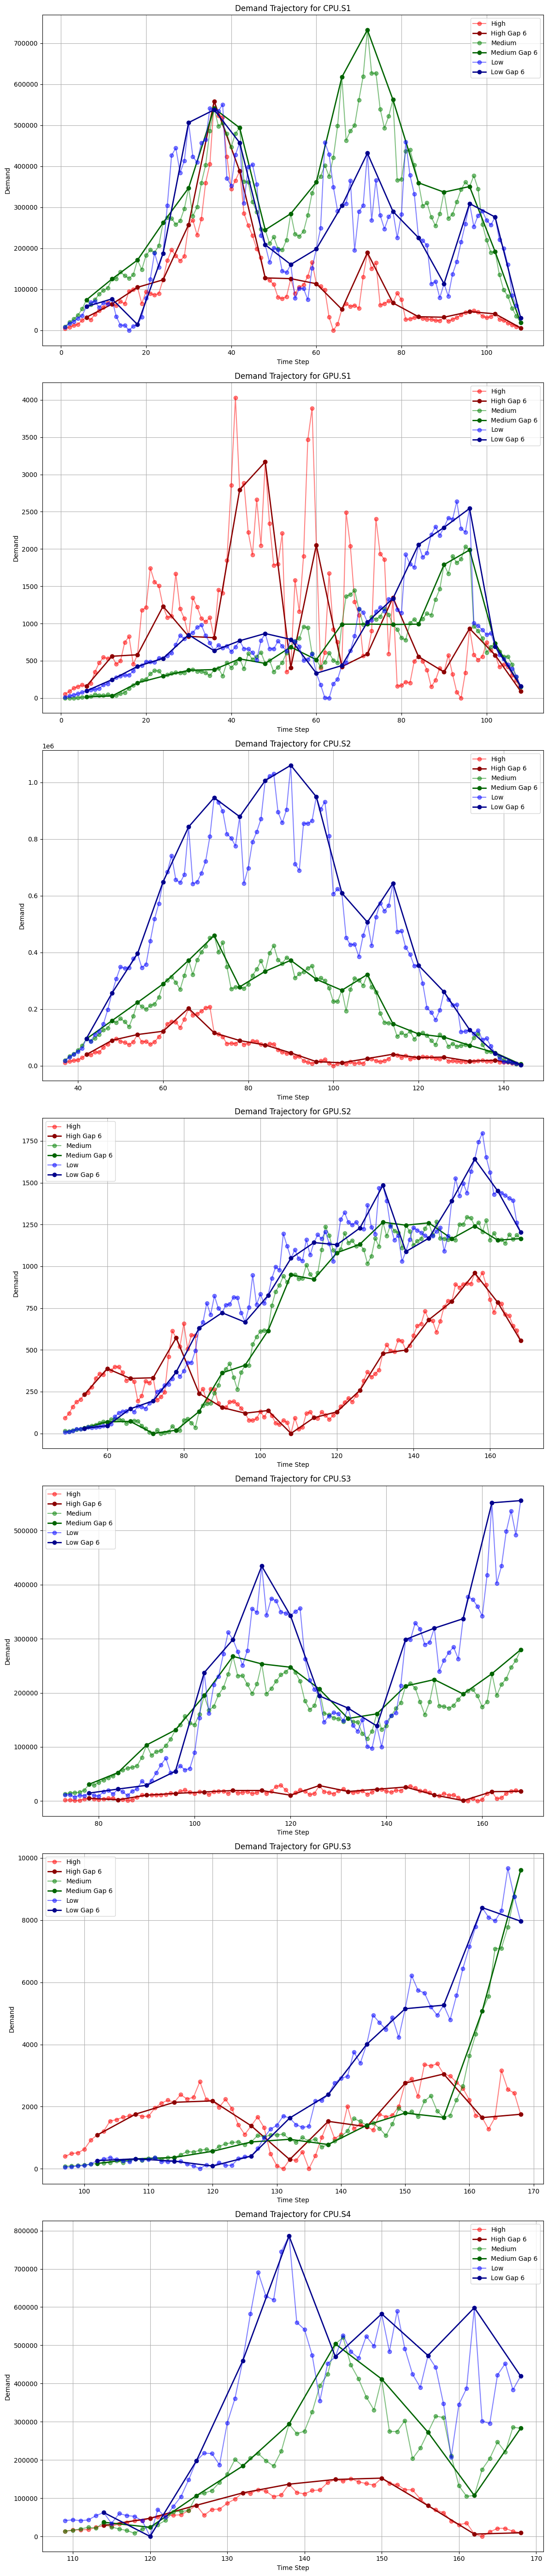

In [67]:
gap_demand_plot(actual_demand, gap_size=6)

In [17]:
gap_df = actual_demand[actual_demand['time_step'] % 6 == 0]
gap_df

In [72]:
def demand_plot(actual_demand: pd.DataFrame, window_size: int = 6, prominence: float = 0.1, width: int = 5):
    server_generations = actual_demand['server_generation'].unique()
    
    # Create subplots vertically
    _, axes = plt.subplots(len(server_generations), 1, figsize=(12, 8 * len(server_generations)))
    plt.subplots_adjust(left=0.2)  # Make room for check buttons
    
    colors = {'high': 'red', 'medium': 'green', 'low': 'blue'}
    
    # Plot for each server generation
    for i, generation in enumerate(server_generations):
        df_gen = actual_demand[actual_demand['server_generation'] == generation]
        
        ax = axes[i]
        
        for column in ['high', 'medium', 'low']:
            color = colors[column]

            # Find peaks (points higher than the previous point)
            peaks = df_gen[df_gen[column] < df_gen[column].shift(3)]

            # Find peaks (points higher than the previous window_size points)
            # peaks = df_gen[df_gen[column] > df_gen[column].rolling(window=window_size, min_periods=1).max().shift(1)]
            # peaks, _ = find_peaks(df_gen[column], prominence=prominence, width=width)

            # Find pits (points lower than the previous window_size points)
            # pits = df_gen[df_gen[column] < df_gen[column].rolling(window=window_size, min_periods=1).min().shift(1)]\
            # valleys, _ = find_peaks(-df_gen[column], prominence=prominence, width=width)

            # Combine peaks and pits, sort by time_step, and drop duplicates
            # extrema = pd.concat([peaks, pits]).sort_values('time_step').drop_duplicates(subset=['time_step', column])
            # extrema = np.sort(np.concatenate([peaks, valleys]))
            
            # Plot original data
            ax.plot(df_gen['time_step'], df_gen[column], label=f'{column.capitalize()}', 
                    color=color, marker='o', alpha=0.5)
            
            # # Plot peaks with darker color
            ax.plot(peaks['time_step'], peaks[column], 
                    color=f'dark{color}', linestyle='-', linewidth=2)
            
            # Plot pits with darker color
            # ax.plot(pits['time_step'], pits[column], 
            #         color=f'dark{color}', linestyle='-', linewidth=2)

            # Plot extrema (peaks and pits) with darker color
            # ax.plot(extrema['time_step'], extrema[column],
            #         color=f'dark{color}', linestyle='-', linewidth=2)
            # ax.plot(df_gen['time_step'].iloc[extrema], df_gen[column].iloc[extrema],
            #         color=f'dark{color}', linestyle='-', linewidth=2, marker='o')
            
        
        ax.set_title(f'Demand Trajectory for {generation}')
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Demand')
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

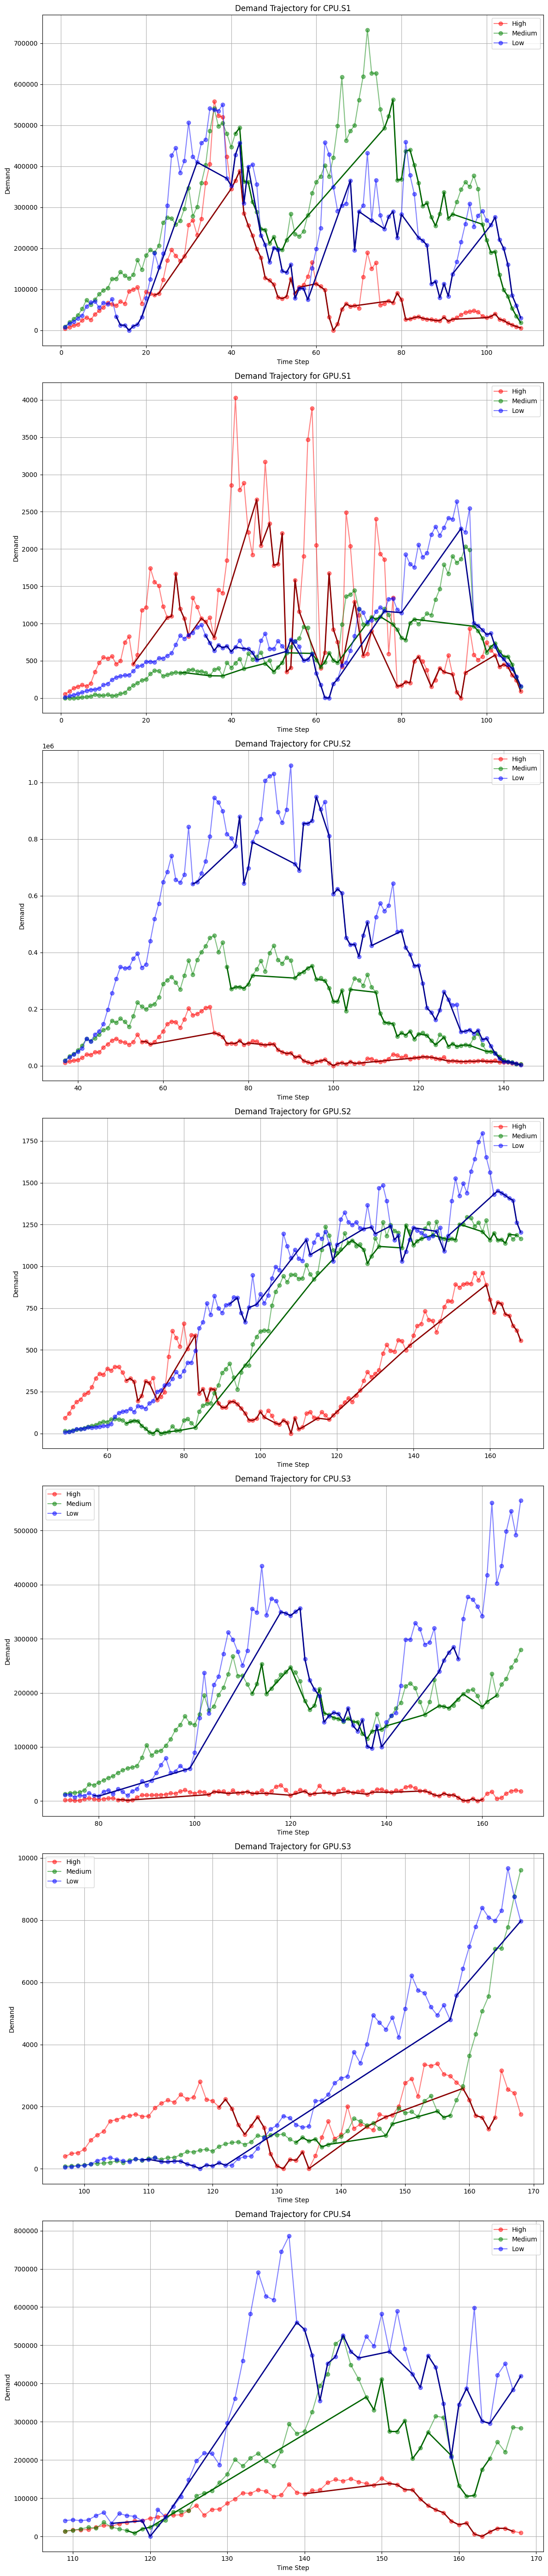

In [73]:
demand_plot(actual_demand, window_size=12)

In [71]:
server_generations = actual_demand['server_generation'].unique()
print(server_generations)

gap_size = 6
gap_dfs = []

for i, generation in enumerate(server_generations):
    df_gen = actual_demand[actual_demand['server_generation'] == generation]
    gap_df = df_gen[df_gen['time_step'] % gap_size == 0].drop('Unnamed: 0', axis=1)
    gap_dfs.append(gap_df)

combined_gap_df = pd.concat(gap_dfs, ignore_index=True).sort_values('time_step')
combined_gap_df.to_csv('combined_gap_df.csv', index=False)

['CPU.S1' 'GPU.S1' 'CPU.S2' 'GPU.S2' 'CPU.S3' 'GPU.S3' 'CPU.S4']


In [ ]:
server_generations = actual_demand['server_generation'].unique()
print(server_generations)

gap_size = 6
gap_dfs = []

for i, generation in enumerate(server_generations):
    df_gen = actual_demand[actual_demand['server_generation'] == generation]
    gap_df = df_gen[df_gen['time_step'] % gap_size == 0].drop('Unnamed: 0', axis=1)
    gap_dfs.append(gap_df)

combined_gap_df = pd.concat(gap_dfs, ignore_index=True).sort_values('time_step')
combined_gap_df.to_csv('combined_gap_df.csv', index=False)

In [4]:
def calculate_volatility(demand_df, window=5):
    # Group by server_generation and calculate rolling std for each latency type
    volatility = demand_df.groupby(['time_step', 'server_generation']).apply(
        lambda x: x[['high', 'medium', 'low']].rolling(window=window).std()
    ).reset_index()
    
    # Combine volatilities across latency types
    volatility['combined_volatility'] = volatility[['high', 'medium', 'low']].mean(axis=1)
    
    return volatility

def get_window_size(volatility, thresholds):
    if volatility < thresholds['low']:
        return 6  # Look further ahead when volatility is low
    elif volatility < thresholds['medium']:
        return 4  # Medium look-ahead for medium volatility
    else:
        return 2  # Short look-ahead for high volatility

In [2]:
import seaborn as sns

In [10]:
historical_volatility = calculate_volatility(actual_demand)

/var/folders/zf/pwcfbfvd57xc3klm5j_db50w0000gn/T/ipykernel_15112/3829625809.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  volatility = demand_df.groupby(['time_step', 'server_generation']).apply(


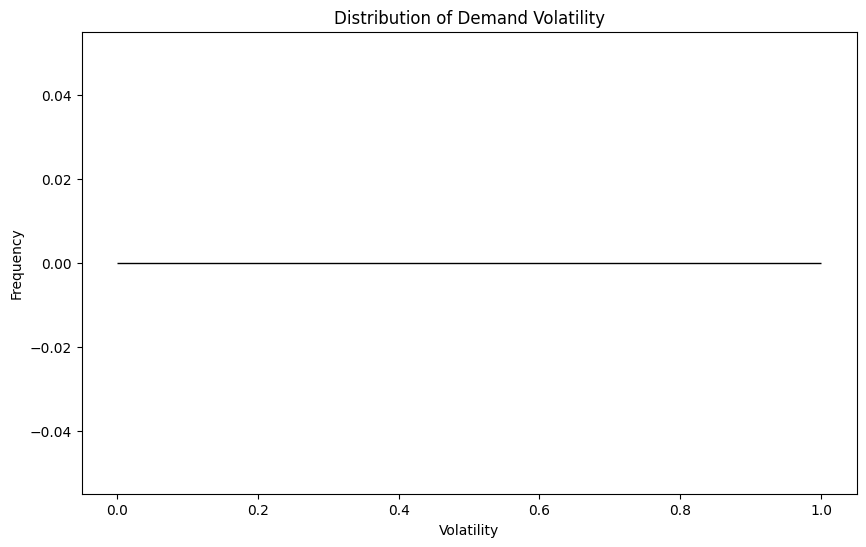

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(historical_volatility['combined_volatility'], kde=True)
plt.title('Distribution of Demand Volatility')
plt.xlabel('Volatility')
plt.ylabel('Frequency')
plt.show()

In [14]:
print(actual_demand.head(10))
print(actual_demand.describe())

   time_step server_generation   high    low  medium
0          1            CPU.S1   4346   7937    9235
1          1            GPU.S1     54     12       0
2          2            CPU.S1   8039  16884   19722
3          2            GPU.S1     90     29       2
4          3            CPU.S1  12276  21346   27524
5          3            GPU.S1    132     41       0
6          4            CPU.S1  15067  29265   37118
7          4            GPU.S1    155     58       3
8          5            CPU.S1  24632  36451   52385
9          5            GPU.S1    176     77      13
        time_step           high           low         medium
count  672.000000     672.000000  6.720000e+02     672.000000
mean    95.214286   36329.888393  1.745416e+05  121725.742560
std     42.940244   68497.415756  2.397422e+05  149745.566954
min      1.000000       0.000000  0.000000e+00       0.000000
25%     63.750000     672.500000  9.785000e+02     904.250000
50%     98.500000    8020.000000  3.162750e+0

In [15]:
def calculate_volatility(demand_df, window=5):
    # Ensure time_step is included and set as index
    demand_df = demand_df.set_index(['time_step', 'server_generation'])
    
    # Calculate percentage change for each demand type
    pct_change = demand_df[['high', 'medium', 'low']].pct_change()
    
    # Calculate rolling standard deviation of percentage changes
    volatility = pct_change.rolling(window=window, min_periods=1).std()
    
    # Combine volatilities across latency types
    volatility['combined_volatility'] = volatility[['high', 'medium', 'low']].mean(axis=1)
    
    return volatility.reset_index()

# Calculate volatility
volatility = calculate_volatility(actual_demand)

# Print some statistics about the volatility
print(volatility['combined_volatility'].describe())

count      670.000000
mean      1039.629580
std       2380.757784
min          1.267240
25%         41.757383
50%        271.196777
75%       1021.751155
max      17906.256928
Name: combined_volatility, dtype: float64


In [16]:
volatility.head()

,time_step,server_generation,high,medium,low,combined_volatility
0,1,CPU.S1,NaN,NaN,NaN,NaN
1,1,GPU.S1,NaN,NaN,NaN,NaN
2,2,CPU.S1,105.258462,NaN,994.898172,550.078317
3,2,GPU.S1,85.943530,0.000072,812.330896,299.424833
4,3,CPU.S1,82.500873,7945.494375,676.573946,2901.523065


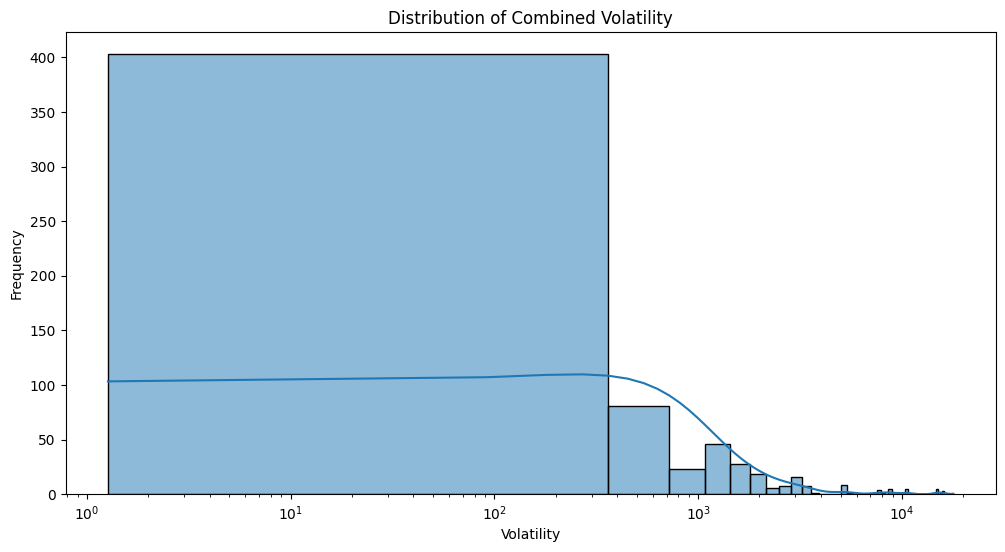

0              NaN
1              NaN
2       550.078317
3       299.424833
4      2901.523065
          ...     
667      12.728824
668      16.869559
669      14.743776
670      14.860624
671      14.288629
Name: combined_volatility, Length: 672, dtype: float64
Calculated thresholds: {'low': nan, 'high': nan}
combined_volatility
2    1.0
Name: proportion, dtype: float64


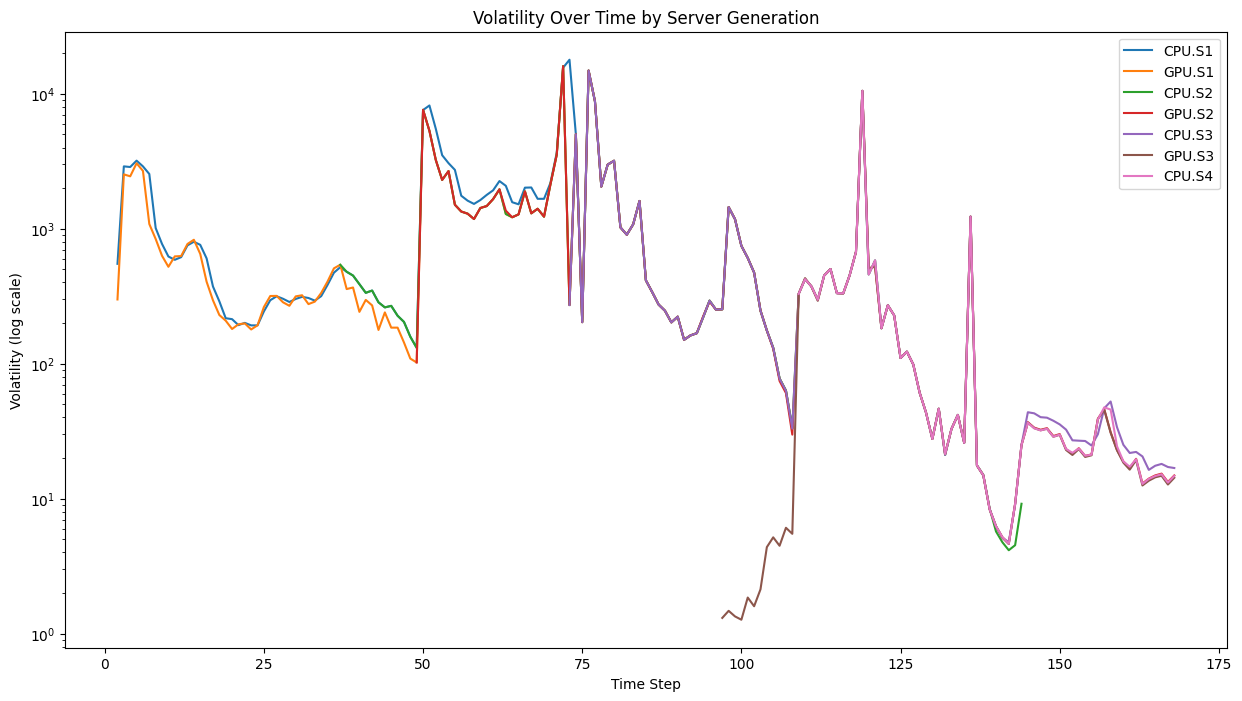

In [20]:
# Visualize the distribution of volatility
plt.figure(figsize=(12, 6))
sns.histplot(volatility['combined_volatility'], kde=True, bins=50)
plt.title('Distribution of Combined Volatility')
plt.xlabel('Volatility')
plt.ylabel('Frequency')
plt.xscale('log')  # Use log scale for x-axis due to wide range
plt.show()

# Calculate percentile-based thresholds
def get_volatility_thresholds(volatility_data, low_percentile=33, high_percentile=67):
    low_threshold = np.percentile(volatility_data, low_percentile)
    high_threshold = np.percentile(volatility_data, high_percentile)
    return {'low': low_threshold, 'high': high_threshold}

thresholds = get_volatility_thresholds(volatility['combined_volatility'])
print(f"Calculated thresholds: {thresholds}")

def get_window_size(volatility, thresholds):
    if volatility < thresholds['low']:
        return 6  # Look further ahead when volatility is low
    elif volatility < thresholds['high']:
        return 4  # Medium look-ahead for medium volatility
    else:
        return 2  # Short look-ahead for high volatility

# Test the window size distribution
window_sizes = volatility['combined_volatility'].apply(lambda x: get_window_size(x, thresholds))
print(window_sizes.value_counts(normalize=True))

# Visualize volatility over time for each server generation
plt.figure(figsize=(15, 8))
for gen in volatility['server_generation'].unique():
    gen_data = volatility[volatility['server_generation'] == gen]
    plt.plot(gen_data['time_step'], gen_data['combined_volatility'], label=gen)
plt.title('Volatility Over Time by Server Generation')
plt.xlabel('Time Step')
plt.ylabel('Volatility (log scale)')
plt.yscale('log')
plt.legend()
plt.show()

In [18]:
# Calculate volatility
volatility = calculate_volatility(actual_demand)

# Check for NaN values
print("NaN values in combined_volatility:")
print(volatility['combined_volatility'].isna().sum())

# Print rows with NaN values
print("\nRows with NaN values:")
print(volatility[volatility['combined_volatility'].isna()])

# Print statistics excluding NaN values
print("\nStatistics excluding NaN values:")
print(volatility['combined_volatility'].describe())

NaN values in combined_volatility:
2

Rows with NaN values:
   time_step server_generation  high  medium  low  combined_volatility
0          1            CPU.S1   NaN     NaN  NaN                  NaN
1          1            GPU.S1   NaN     NaN  NaN                  NaN

Statistics excluding NaN values:
count      670.000000
mean      1039.629580
std       2380.757784
min          1.267240
25%         41.757383
50%        271.196777
75%       1021.751155
max      17906.256928
Name: combined_volatility, dtype: float64


In [19]:
def calculate_volatility(demand_df, window=5):
    # Ensure time_step is included and set as index
    demand_df = demand_df.set_index(['time_step', 'server_generation'])
    
    # Calculate percentage change for each demand type
    pct_change = demand_df[['high', 'medium', 'low']].pct_change()
    
    # Replace infinity values with NaN
    pct_change = pct_change.replace([np.inf, -np.inf], np.nan)
    
    # Calculate rolling standard deviation of percentage changes
    volatility = pct_change.rolling(window=window, min_periods=1).std()
    
    # Combine volatilities across latency types
    volatility['combined_volatility'] = volatility[['high', 'medium', 'low']].mean(axis=1)
    
    # For the first time step, use the standard deviation of the next 'window' steps
    first_window = demand_df.groupby(level=1).apply(lambda x: x.iloc[:window].std())
    first_window['combined_volatility'] = first_window[['high', 'medium', 'low']].mean(axis=1)
    
    # Replace NaN values in the first time step with the calculated values
    volatility.loc[volatility.index.get_level_values('time_step') == 1, 'combined_volatility'] = \
        first_window['combined_volatility']
    
    return volatility.reset_index()

# Recalculate volatility
volatility = calculate_volatility(actual_demand)

# Check for NaN values
print("NaN values in combined_volatility:")
print(volatility['combined_volatility'].isna().sum())

# Print statistics
print("\nStatistics of combined_volatility:")
print(volatility['combined_volatility'].describe())

NaN values in combined_volatility:
2

Statistics of combined_volatility:
count      670.000000
mean      1039.629580
std       2380.757784
min          1.267240
25%         41.757383
50%        271.196777
75%       1021.751155
max      17906.256928
Name: combined_volatility, dtype: float64
